In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
pd.set_option('display.max_columns', None)

In [2]:
# 1. Load the data -----------------------------------------------------------
df = pd.read_excel("HumanStudyResults.xlsx")

mapping_question_to_hiddenmethod = {
    'Butterfly': {'A':'AA', 'B':'LIME',  'C':'BPT',     'D':'GradCAM'},
    'Ladybug'  : {'A':'LIME','B':'BPT',  'C':'GradCAM', 'D':'AA'},
    'StreetSign':{'A':'GradCAM','B':'AA','C':'BPT',     'D':'LIME'},
    'Bench'    : {'A':'BPT', 'B':'AA',   'C':'LIME',    'D':'GradCAM'},
}

# 2. Expand each ranked string into (subject, question, method, rank) rows ---
records = []
for _, row in df.iterrows():
    for q in mapping_question_to_hiddenmethod:
        for pos, letter in enumerate(row[q], start=1):    # best→1, worst→4
            records.append({
                "Subject": row.iloc[0],
                "Question": q,
                "Method": mapping_question_to_hiddenmethod[q][letter],
                "Rank": pos,
            })
long = pd.DataFrame(records)

# 3. Compute average rank ----------------------------------------------------
avg_rank = long.groupby("Method")["Rank"].mean().sort_values()
print(avg_rank)

Method
BPT        1.7875
GradCAM    2.4125
LIME       2.5625
AA         3.2375
Name: Rank, dtype: float64


In [3]:
# # 4. Plot per-method rank histograms (one figure per method) -----------------
# for m in avg_rank.index:
#     plt.figure()
#     long[long.Method == m]["Rank"].hist(
#         bins=[0.5, 1.5, 2.5, 3.5, 4.5], rwidth=0.9
#     )
#     plt.xticks([1, 2, 3, 4])
#     plt.xlabel("Rank (1 = best)")
#     plt.ylabel("Frequency")
#     plt.title(f"Distribution of ranks for {m}")
#     plt.show()


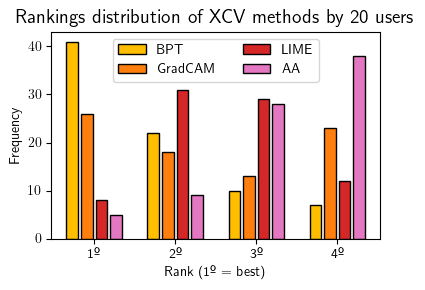

In [ ]:
# ---------------------------------------------------------------------------
# 3.  Count how often each method received each rank ------------------------
# ---------------------------------------------------------------------------
counts = (long
          .groupby(["Method", "Rank"])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=[1, 2, 3, 4])           # ensure rank order
          .loc[["BPT", "GradCAM", "LIME", "AA"]])  # legend order

# ---------------------------------------------------------------------------
# 4.  Plot single grouped histogram (grouped bar chart) ---------------------
# ---------------------------------------------------------------------------
ranks = np.arange(1, 5)          # x-axis positions for rank 1-4
bar_w = 0.18                     # width of each bar
offsets = np.linspace(-1.5*bar_w, 1.5*bar_w, len(counts))

plt.figure(figsize=(4, 3))
colours = ["#ffbf00", "#ff7f0e", "#d62728", "#e377c2"]  # optional: custom colours

for (i, (method, row)) in enumerate(counts.iterrows()):
    plt.bar(ranks + offsets[i], row.values,
            width=0.8*bar_w, label=method, color=colours[i], edgecolor='black')

plt.xticks(ranks, [f'{rank}º' for rank in [1, 2, 3, 4]])
plt.xlabel("Rank (1º = best)")
plt.ylabel("Frequency")
plt.title("Rankings distribution of XCV methods by 20 users", fontsize=14)
plt.legend(frameon=True, ncols=2)
plt.tight_layout()
plt.savefig(f'../paper_figures/human_study_summary.pdf', transparent=True, dpi=150, 
            bbox_inches='tight', pad_inches=0.02)
plt.show()

In [ ]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp  # pip install scikit-posthocs

# --------------------------------------------------------
# 3.  Pivot to subjects × methods (for Friedman test)
# --------------------------------------------------------
pivot = (long
         .pivot_table(index='Subject', columns='Method', values='Rank')
         .loc[:, ['BPT', 'GradCAM', 'LIME', 'AA']])   # fix column order

# --------------------------------------------------------
# 4.  Friedman test (non-parametric repeated-measures ANOVA)
# --------------------------------------------------------
stat, pvalue = friedmanchisquare(*[pivot[col].values for col in pivot.columns])
print(f"Friedman χ² = {stat:.2f},  p-value = {pvalue:.4f}")

# --------------------------------------------------------
# 5.  Post-hoc Nemenyi pairwise comparisons
# --------------------------------------------------------
nemenyi = sp.posthoc_nemenyi_friedman(pivot.values)
nemenyi.index = nemenyi.columns = pivot.columns  # label rows/cols
print("\nNemenyi p-value matrix:\n", nemenyi)

Friedman χ² = 19.56,  p-value = 0.0002

Nemenyi p-value matrix:
 Method        BPT   GradCAM      LIME        AA
Method                                         
BPT      1.000000  0.079307  0.091936  0.000081
GradCAM  0.079307  1.000000  0.999918  0.203470
LIME     0.091936  0.999918  1.000000  0.180226
AA       0.000081  0.203470  0.180226  1.000000
